# Audio Signal Exploration

In [169]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
import os

from python_speech_features import mfcc, logfbank

In [151]:
mixed_dir = ("../../../mixed")
sample = mixed_dir + "/" + os.listdir(mixed_dir)[0]

In [152]:
### Read a file with uncompressed waveform as a memory-mapped file ###

"""
Memory-mapped files behave also like strings. They are mutable. 
So, a single character in them can be changed. Memory mapped files allow accessing a small segment on the disk. 
They have limited size (for example, 2GB on 32-bit system).

"""


'\nMemory-mapped files behave also like strings. They are mutable. \nSo, a single character in them can be changed. Memory mapped files allow accessing a small segment on the disk. \nThey have limited size (for example, 2GB on 32-bit system).\n\n'

In [153]:
# Read in wav file

wavfile.read(sample,mmap=True)

(44100, memmap([-5699, -6056, -6501, ...,  5559,  5281,  5403], dtype=int16))

In [154]:
# Get a look at signal data

sampling_freq, signal = wavfile.read(sample)
print(signal, "\n")

[-5699 -6056 -6501 ...  5559  5281  5403] 



In [155]:
# Get general information on wav file

"""
Sampling frequency 44100 of samples per second (44100 hertz) is a CD sound quality. 
In 3 seconds the number of samples is 132300.
"""

print('Sampling frequency: ',sampling_freq)
print('\nSignal shape: ',signal.shape)
print('\nData type: ',signal.dtype)
print('\nSignal duration: ',round(signal.shape[0] / float(sampling_freq),2), 'seconds')

Sampling frequency:  44100

Signal shape:  (80658,)

Data type:  int16

Signal duration:  1.83 seconds


In [156]:
# Normalize the signal

s_lo, s_hi = np.min(signal), np.max(signal)
print('Range before normalization: ',s_lo, s_hi)

signal = signal/np.power(2,15)
s_lo, s_hi = np.min(signal), np.max(signal)
print('Range after normalization: ',s_lo,s_hi)

Range before normalization:  -32768 32767
Range after normalization:  -1.0 0.999969482421875


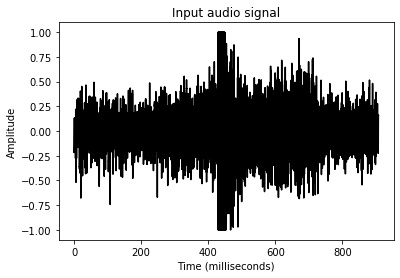

In [157]:
# Select a small component of the signal

signal = signal[:40000]

time_axis = 1000 * np.arange(0,len(signal),1) / float(sampling_freq) # time in seconds

plt.plot(time_axis,signal,color='black')
plt.xlabel('Time (milliseconds)')
plt.ylabel('Amplitude')
plt.title('Input audio signal')
plt.show()

In [158]:
### Transforming audio signals to frequency domain ###



If signal in time domain is $\{x_t\}=x_0,\ldots,x_{N-1}$, then its DFT is the signal in frequency domain, i.e. magnitude or energy (dB) as function of frequency 

$$\{\hat{x}_k\}=\hat{x}_0,\ldots,\hat{x}_{N-1},$$

$$\hat{x}_k =\sum_{t=0}^{N-1}x_t \left( \cos \left( \frac{2 \pi}{N}kt \right) -i \sin \left( \frac{2 \pi}{N}kt \right) \right).$$

Then normalized frequency domain signal is 
$$\frac{\hat{x}_k}{N},~k=0,\ldots,\frac{N}{2}.$$

where N is the length of the time domain.

Including only half of the time range is due to Nyquist frequency. The Nyquist frequency is the highest estimated frequency, which is half of the sampling rate of a discrete signal processing signal. The fundamental frequency is the lowest estimated frequency and is equal to 1/N. 

In [159]:
# Apply Fourier Transform. 

freq_signal = np.fft.fft(signal)
print(freq_signal.shape)
freq_signal # array of numpy.complex128

# We note that there are as many frequencies as there are discrete time steps

(40000,)


array([ -26.59008789  +0.j        ,  127.31810382 +20.08192801j,
       -121.10326938+120.3999466j , ...,    0.48653676+152.76632515j,
       -121.10326938-120.3999466j ,  127.31810382 -20.08192801j])

In [160]:
# Multiplying two imaginary numbers yields a real number

(freq_signal[1]*freq_signal[1])

(15806.61572770348+5113.585991292094j)

In [161]:
# Normalize frequency domain signal by dividing the first half length of the DFT array by sampling frequency 
# (i.e. the number of time steps).

len_signal = len(signal)
print("length of the signal in time:", len_signal)
len_half = np.ceil((len_signal + 1) / 2.0).astype(np.int) 
print("half that length", len_half)

# Dividing first half of DFT (freq signal) by sampling freq (len signal)
freq_signal = abs(freq_signal[0:len_half]) / len_signal
freq_signal

length of the signal in time: 40000
half that length 20001


array([6.64752197e-04, 3.22230347e-03, 4.26923215e-03, ...,
       5.72933253e-05, 6.77364881e-05, 5.66894531e-05])

The power spectrum of the signal is then defined as $\{ |\hat{x}_k|^2 \}$.

In [162]:
# Calculating power spectrum: 

"""
Spectral Density, spectrum, or power spectrum of a time series describes the distribution of power (variance) 
into the frequency components composing that signal and is directly linked to the autocovariance time domain 
representation. Spectral Density, S_xx (λ), of a weakly stationary time series x_t is the Fourier transform of 
its autocovariance γ_k:
"""

freq_signal **= 2    
print(freq_signal.shape)

len_fts = len(freq_signal)

(20001,)


Power spectrum has property $S_{xx}(\lambda)=S_{xx}(-\lambda)$ which is called a two-sided power spectrum. 



In [163]:
"""
Typical analysis is done only with one-sided spectrum, i.e. with half of the power spectrum sequence. 
To preserve the total amount of energy shown in the half-range double the spectrum with adjustment 
for cases of even or odd length.Calculation of power spectrum is an important step of extracting feature
from speech signals. See more on feature extraction in a later section of the document.
"""

if len_signal % 2:
    freq_signal[1:len_fts] *= 2
else:
    freq_signal[1:len_fts-1] *= 2

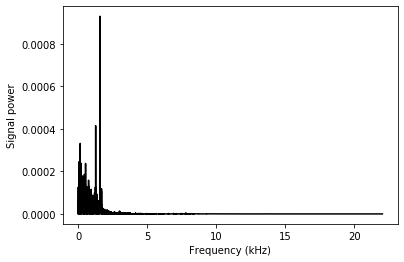

In [165]:
# Now plot the power spectrum.

# Build the X axis
x_axis = np.arange(0, len_half, 1) * (sampling_freq / len_signal) / 1000.0

# Plot the figure
plt.figure()
plt.plot(x_axis, freq_signal, color='black')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Signal power')
plt.show()

It is common to show spectrum in logarithmic units (decibels, dB). Logarithmic scale allows viewing wider dynamic ranges, i.e. small signal in the presence of large signal. 

General definition of decibel unit is 
$$1dB=10\log_{10} \left(\frac{P}{P_r} \right),$$
where $P$ is the measured power and $P_r$ is the reference power (in our case 1).



In [166]:
# Extract the power value in dB:

signal_power = 10 * np.log10(freq_signal)
signal_power

array([-63.54680437, -46.82637128, -44.38270462, ..., -81.82761946,
       -80.37324652, -84.92995465])

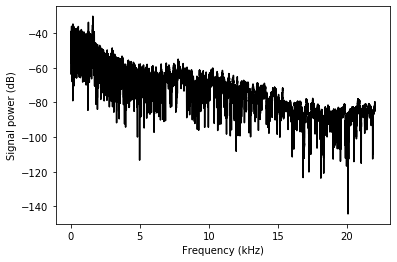

In [167]:
# Now plot the power spectrum in dB.

# Build the X axis
x_axis = np.arange(0, len_half, 1) * (sampling_freq / len_signal) / 1000.0

# Plot the figure
plt.figure()
plt.plot(x_axis, signal_power, color='black')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Signal power (dB)')
plt.show()

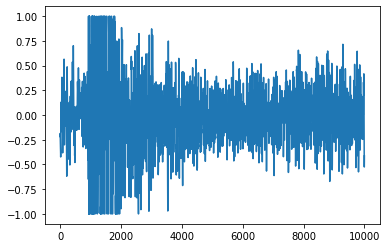

In [170]:
signal = signal[18000:28000]
plt.plot(signal)

Extract features: Mel Frequency Cepstral Coefficients (MFCC). Recall from lecture slides how MFCC are calculated.

Function `mfcc()` has syntax:

`mfcc(signal, samplerate=16000, winlen=0.025, winstep=0.01, numcep=13, nfilt=26, nfft=512, lowfreq=0, highfreq=None, preemph=0.97, ceplifter=22, appendEnergy=True, winfunc=<function <lambda> at 0x7f06854d6378>)`,
    
where:    
- `signal`: the audio signal from which to compute features. Should be an N*1 array
- `samplerate`: the sample rate of the signal
- `winlen`: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
- `winstep`: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
- `numcep`: the number of cepstrum coefficients to return, default 13
- `nfilt`: the number of filters in the filterbank, default 26
- `nfft`: the FFT size. Default is 512.
- `lowfreq`: lowest band edge of mel filters. In Hz, default is 0.
- `highfreq`: highest band edge of mel filters. In Hz, default is samplerate/2 (Nyquist)
- `preemph`: apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97.
- `ceplifter`: apply a lifter to final cepstral coefficients. 0 is no lifter. Default is 22.
- `appendEnergy`: if this is true, the zero lag cepstral coefficient is replaced with the log of the total frame energy. Default is True
- `winfunc`: the analysis window to apply to each frame. By default no window is applied. You can use numpy window functions here e.g. winfunc=numpy.hamming

The function returns a numpy array of size (`NUMFRAMES` by `numcep`) containing features. Each row holds 1 feature vector.

In [180]:
print(sampling_freq)
features_mfcc = mfcc(signal, sampling_freq)
features_mfcc[0:3]
print(features_mfcc.shape)
# Below array is 22 windows by 13 cepstral coefficients

44100
(22, 13)


In [172]:
# Print the parameters for MFCC.

print('\nMFCC:\nNumber of windows =', features_mfcc.shape[0])
print('Length of each feature =', features_mfcc.shape[1])
print('Mfcc shape: ',features_mfcc.shape)


MFCC:
Number of windows = 22
Length of each feature = 13
Mfcc shape:  (22, 13)


Plot 3 features from frames 0, 50, 100.

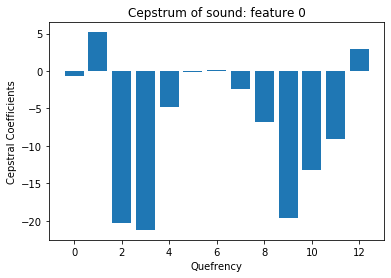

array([ -0.59924783,   5.18855552, -20.2759358 , -21.22564062,
        -4.83195072,  -0.09009625,   0.1435127 ,  -2.46233521,
        -6.80416019, -19.62604986, -13.20060153,  -9.1095019 ,
         3.00147715])

In [179]:
x_ax=range(features_mfcc.shape[1])
plt.bar(x_ax,features_mfcc[0],)
plt.xlabel('Quefrency')
plt.ylabel('Cepstral Coefficients')
plt.title('Cepstrum of sound: feature 0')
plt.show()
features_mfcc[0]

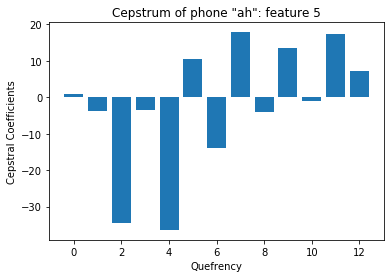

array([  1.02105721,  -3.90774502, -34.5999518 ,  -3.52453447,
       -36.40086096,  10.39702415, -13.95493793,  17.83031405,
        -3.98398643,  13.50225376,  -1.05015502,  17.33101599,
         7.26036168])

In [184]:
plt.bar(x_ax,features_mfcc[5],)
plt.xlabel('Quefrency')
plt.ylabel('Cepstral Coefficients')
plt.title('Cepstrum of phone "ah": feature 5')
plt.show()
features_mfcc[5]

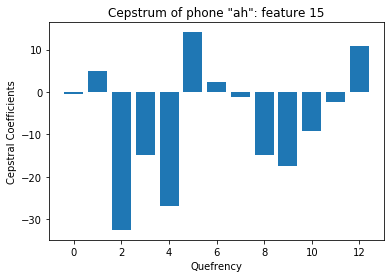

array([ -0.51953126,   4.94121435, -32.495876  , -14.81742116,
       -26.79432361,  14.08280413,   2.26197164,  -1.17198888,
       -14.87539261, -17.49511429,  -9.17686647,  -2.36653544,
        10.89258753])

In [185]:
plt.bar(x_ax,features_mfcc[15],)
plt.xlabel('Quefrency')
plt.ylabel('Cepstral Coefficients')
plt.title('Cepstrum of phone "ah": feature 15')
plt.show()
features_mfcc[15]

Plot heat map of all features. Interpret color codes by comparing with the printed column 20 of the transposed MFCC matrix.

In [27]:
print(features_mfcc.shape)
print(features_mfcc.T[:,20])

(124, 13)
[ 22.19603486  10.81052601 -27.3485195  -40.80158286  -8.04261525
   6.62628477 -11.34477973 -14.08160422 -14.5493616   -2.14966308
 -14.62196892  -7.51295313   2.04559786]


Text(0.5,1.05,'MFCC')

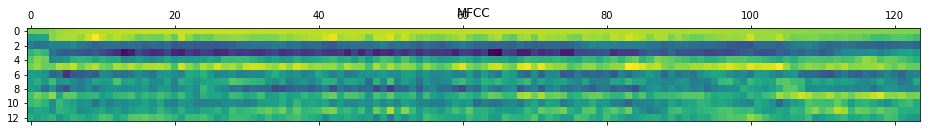

In [28]:
plt.matshow(features_mfcc.T)
plt.title('MFCC')

Plot filterbank matrix. Make sense of color codes by comparing the plot with the printed column 100 of the transposed matrix.


Filter bank:
Number of windows = 124
Length of each feature = 26
[ 12.04560179  13.28830683  11.77826366  12.39058045  14.01578833
  13.06383529  12.73133523  14.70399259  16.20947787  16.13935284
  14.50328141  16.1827176   15.83816027  13.92324499  12.19804285
  10.66094525   9.72033785   9.89420661   9.79355425   9.06620216
   9.74895758  10.70067082   9.26559566   9.2987448    8.57484408
   6.90365661]


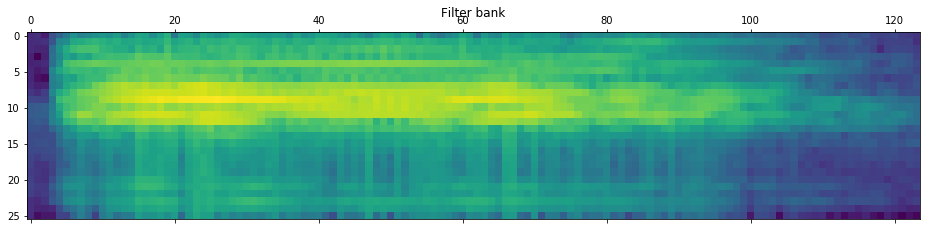

In [29]:
# Extract the Filter Bank features
features_fb = logfbank(signal, sampling_freq,nfft=1024)

# Print the parameters for Filter Bank 
print('\nFilter bank:\nNumber of windows =', features_fb.shape[0])
print('Length of each feature =', features_fb.shape[1])
print(features_fb.T[:,100])
# Plot the features
features_fb = features_fb.T
plt.matshow(features_fb)
plt.title('Filter bank')

plt.show()

# Recognizing spoken words

Previous section showed how to extract features from waveform of the word in the form of MFCC of a short segment of the signal.

Vectors of features form a time series that may be well described as process of transitioning between finite number of states, i.e. Markov chain.

States of the Markov chain may correspond to some spoken language patterns, like phonemes, but typically they are some unknown acoustic patterns that are contained in phonemes. So, it is reasonable to assume that states of the Markov chain are not known.

Thus traditional method for recognizing a word contained in the signal waveform is based on hidden Markov models.   

## Training model


In [30]:
import os
import warnings
import numpy as np
from scipy.io import wavfile
from hmmlearn import hmm      # hidden Markov model
from python_speech_features import mfcc
from sklearn.externals import joblib

Define a class to train the HMM.

Parameters of `hmm.GaussianHMM()`:

- `n_components`: number of states of HMM
- `covariance_type`: type of covariance matrix for each state. Each state is a random vector. This parameter is a string defining the type of covariance matrix of this vector. Defaults to `"diagonal"`

In [31]:
class ModelHMM(object):
    def __init__(self, num_components=8, num_iter=1000):
        self.n_components = num_components
        self.n_iter = num_iter
    # Define the covariance type and the type of HMM:
        self.cov_type = 'diag'
        self.model_name = 'GaussianHMM'
    #Initialize the variable in which we will store the models for each word:
        self.models = []
    #Define the model using the specified parameters:
        self.model = hmm.GaussianHMM(n_components=self.n_components,
                covariance_type=self.cov_type,n_iter=self.n_iter)

    #Define a method to train the model
    # 'training_data' is a 2D numpy array where each row has length of number of mfcc coefficients
    def train(self, training_data):
        np.seterr(all='ignore')
        cur_model = self.model.fit(training_data)
        self.models.append(cur_model)

    # Define a method to compute log likelihood score for input features
    def compute_score(self, input_data):
        return self.model.score(input_data)  # model.score returns log likelihood of sample input_data

Define a function that takes folder with training sample for one word and trains HMM with it.

In [32]:
def build_one_model(input_folder,num_states,num_cep_coeff):
    # input_folder: path to the folder containing training wav files with the word
    # num_states: number of hidden states in HMM
    # num_cep_coeff: number of MFCC features extracted from each time window
    
    X = np.array([]) # features
    
    training_files = [x for x in os.listdir(input_folder) if x.endswith('.wav')]
    
    for filename in training_files:
        # Extract the current filepath and read the file
        filepath = os.path.join(input_folder, filename)
        sampling_freq, signal = wavfile.read(filepath)
        
        # Extract features
        # Default values:
        # winlen=0.025, winstep=0.01, nfilt=26, nfft=512,
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            features_mfcc = mfcc(signal, sampling_freq, numcep= num_cep_coeff)
        
        # Append features to the variable X
        if len(X) == 0:
            X = features_mfcc
        else:
            X = np.append(X, features_mfcc, axis=0)
    
    # Initiate HMM model object
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore',category=DeprecationWarning)
        model = ModelHMM(num_components=num_states)

    # Train HMM model, calculate likelihood of the sample by the trained model
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore',category=DeprecationWarning)
        model.train(X)
        model_score = model.compute_score(X)
        
    return model, model_score, num_cep_coeff

Select one of the subfolders of folder `data` with fruit names. Leave one of the sample records for validation and train model using the rest of the files.

Try training model with different numbers of states and cepstrum features and compare AIC values.

AIC for HMM model can be calculated as 
$$-2LogLik+2p,$$ where $p$ is the number of parameters:
$$p=n^2+kn-1,$$ $n$ is the number of states, $k$ is the number of parameters of distribution of observations (emission distribution). For Gaussian emission distribution $k=2$. 

See ["Hidden Markov Models for Time Series: An Introduction Using R", Second Edition, by W.Zucchini, I.L.MacDonald, R.Langrock, &copy; 2016 W.Zucchini, I.L.MacDonald, R.Langrock, CRC Press](https://www.amazon.com/Hidden-Markov-Models-Time-Introduction/dp/1584885734) for more information.


In [33]:
def hmm_aic(LLik,n,k):
    return -2*LLik+2*(n*n+k*n-1)

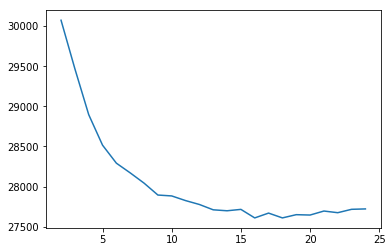

In [40]:
my_input_folder = './data/apple'
AIC_scores = np.array([])
for n_st in range(2,25,1):
    out_fun_apple = build_one_model(my_input_folder,num_states=n_st,num_cep_coeff=8)
    AIC_scores = np.append(AIC_scores,hmm_aic(LLik=out_fun_apple[1],n=n_st,k=5))
#    print(n_st,hmm_aic(LLik=out_fun_apple[1],n=n_st,k=2))
plt.plot(range(2,25,1),AIC_scores)
    

Plotting results for different values of number of states and numbers of cepstral coefficients suggests that (at least for this word "apple") number of hidden states may be between 10 and 15 with a relatively small number of cepstral coefficients in features.

However there is known tendency of AIC to overestimate number of hidden states. 

Both parameters also depend on complexity and lengths of words.

Estimate model for word "apple" with 13 hidden states and 2 cepstral coefficients.

In [41]:
model_apple = build_one_model(my_input_folder,num_states=13,num_cep_coeff=8)
model_apple

(<__main__.ModelHMM at 0x7f47c638a9b0>, -13632.384778694797, 8)

Train models for the whole vocabulary contained in folder `data`.

In [43]:
def build_models(input_folder):
    
    # input_folder contains subfolders with samples of words in wav files
    
    # Initialize the variable to store all the models
    speech_models = []

    # Parse the input directory
    for dirname in os.listdir(input_folder):

        # Get name of subfolder 
        subfolder = os.path.join(input_folder, dirname)

        if not os.path.isdir(subfolder): 
            continue

        # Extract label
        label = subfolder[subfolder.rfind('/') + 1:]
        
        # Fit model for label
        model = build_one_model(subfolder,num_states=13,num_cep_coeff=8)
        
        # Add the model to the list
        speech_models.append((model, label))
        
        # Reset model variable
        model = None

    return speech_models


In [44]:
fruit_models = build_models('./data')
fruit_models

[((<__main__.ModelHMM at 0x7f47c62b0f28>, -25401.773925595422, 8), 'orange'),
 ((<__main__.ModelHMM at 0x7f47c62c1400>, -21007.794762733552, 8), 'peach'),
 ((<__main__.ModelHMM at 0x7f47c62c1780>, -14245.373120339475, 8), 'lime'),
 ((<__main__.ModelHMM at 0x7f47c62c1390>, -13288.934422558497, 8), 'kiwi'),
 ((<__main__.ModelHMM at 0x7f47c62c1630>, -13665.501026176857, 8), 'apple'),
 ((<__main__.ModelHMM at 0x7f47c62c1b38>, -16759.840556198189, 8), 'banana'),
 ((<__main__.ModelHMM at 0x7f47c62c1fd0>, -19809.681766050515, 8),
  'pineapple')]

Models can be saved in **pickled** or **serialized** format or inversly transformed using `joblib.dump()` and `joblib.load()` from `sklearn.externals`. 

In [45]:
joblib.dump(fruit_models,'saved_fruit_models.pkl')

['saved_fruit_models.pkl']

In [46]:
joblib.load('saved_fruit_models.pkl')

[((<__main__.ModelHMM at 0x7f47c62b9d68>, -25401.773925595422, 8), 'orange'),
 ((<__main__.ModelHMM at 0x7f47c62d8ba8>, -21007.794762733552, 8), 'peach'),
 ((<__main__.ModelHMM at 0x7f47c6253198>, -14245.373120339475, 8), 'lime'),
 ((<__main__.ModelHMM at 0x7f47c6253358>, -13288.934422558497, 8), 'kiwi'),
 ((<__main__.ModelHMM at 0x7f47c62534a8>, -13665.501026176857, 8), 'apple'),
 ((<__main__.ModelHMM at 0x7f47c6253668>, -16759.840556198189, 8), 'banana'),
 ((<__main__.ModelHMM at 0x7f47c6253828>, -19809.681766050515, 8),
  'pineapple')]

## Validating model

Once model is trained it can be validated and used for words recognition by checking log likelihood scores of different words.

Create a function that takes a trained model and a path to wav file and returnes log likelihood of that word, given the model.

In [47]:
def score_one_word(trained_model,test_file_path):
    # trained_model: ModelHMM object with trained model
    # test_file_path: path to wav file
    
    sampling_freq, signal = wavfile.read(test_file_path)
    num_cep_coeff = trained_model[2]
    
    # Extract features
    # Default values:
    # winlen=0.025, winstep=0.01, nfilt=26, nfft=512,
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        features_mfcc = mfcc(signal, sampling_freq, numcep= num_cep_coeff)
        
        # Calculate log likelihood
        word_score = trained_model[0].compute_score(features_mfcc)
    return word_score

Try the function by comparing scores of words "apple" and "banana", both words are from the folder of words not used in training. 

In [48]:
score_apple = score_one_word(model_apple,'./Validation/apple15.wav')
score_banana = score_one_word(model_apple,'./Validation/banana15.wav')
score_apple, score_banana

(-1066.297913925081, -1873.0187150873126)

As expected, likelihood of "apple" is much higher than likelihood of "banana".

## Recognizing words

In [49]:
def recognize_words(test_files_folder):
    results = []
    
    for filename in os.listdir(test_files_folder):

        # Get the name of the subfolder 
        current_file = os.path.join(test_files_folder,filename)
        
        # Extract true label from file name
        start_index = current_file.find('/') + 1
        end_index = current_file.rfind('15')
        true_label = current_file[start_index:end_index]
        print('\n\nTrue label: ',true_label)
 
        max_score = -float('inf')
        output_label = None

        # Loop through vocabulary models
        for item in fruit_models:
            trained_model, label = item
            current_score = score_one_word(trained_model,current_file)
            if current_score > max_score:
                max_score = current_score
                output_label = label
            print('\nNext model')
            print('Current label, score: ',label,current_score)
            print('Output label, max score: ',output_label,max_score)
        results.append((true_label,output_label))
    return results

In [50]:
recognize_words('Validation')



True label:  kiwi

Next model
Current label, score:  orange -2016.97044204
Output label, max score:  orange -2016.97044204

Next model
Current label, score:  peach -1563.19697231
Output label, max score:  peach -1563.19697231

Next model
Current label, score:  lime -2269.85640194
Output label, max score:  peach -1563.19697231

Next model
Current label, score:  kiwi -1117.83644028
Output label, max score:  kiwi -1117.83644028

Next model
Current label, score:  apple -2233.16617599
Output label, max score:  kiwi -1117.83644028

Next model
Current label, score:  banana -1683.07731385
Output label, max score:  kiwi -1117.83644028

Next model
Current label, score:  pineapple -1569.98592889
Output label, max score:  kiwi -1117.83644028


True label:  peach

Next model
Current label, score:  orange -2240.48838728
Output label, max score:  orange -2240.48838728

Next model
Current label, score:  peach -1673.73856544
Output label, max score:  peach -1673.73856544

Next model
Current label, sc

[('kiwi', 'kiwi'),
 ('peach', 'peach'),
 ('orange', 'orange'),
 ('apple', 'apple'),
 ('lime', 'lime'),
 ('pineapple', 'pineapple'),
 ('banana', 'banana')]